<a href="https://colab.research.google.com/github/Aaryanverma/image_search/blob/main/clip_recommend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/alexeygrigorev/clothing-dataset.git

In [ ]:
# Clone the CLIP repository
!git clone https://github.com/openai/CLIP.git

In [ ]:
!pip install ftfy

In [ ]:
!mv /content/CLIP/clip/*.py .
!mv /content/CLIP/clip/*.gz .

in clip.py, rewrite:

from .model import build_model **-->** from model import build_model

from .simple_tokenizer import SimpleTokenizer as _Tokenizer **-->** from simple_tokenizer import SimpleTokenizer as _Tokenizer

In [ ]:
from pathlib import Path

# Set the path to the photos
photos_path = Path("clothing-dataset") / "images"

# List all JPGs in the folder
photos_files = list(photos_path.glob("*.jpg"))

# Print some statistics
print(f"Photos found: {len(photos_files)}")

Photos found: 5756


In [ ]:
import clip
import torch
from PIL import Image

# Load the open CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Function that computes the feature vectors for a batch of images
def compute_clip_features(photos_batch):
    # Load all the photos from the files
    photos = [Image.open(photo_file) for photo_file in photos_batch]
    
    # Preprocess all photos
    photos_preprocessed = torch.stack([preprocess(photo) for photo in photos]).to(device)

    with torch.no_grad():
        # Encode the photos batch to compute the feature vectors and normalize them
        photos_features = model.encode_image(photos_preprocessed)
        photos_features /= photos_features.norm(dim=-1, keepdim=True)

    # Transfer the feature vectors back to the CPU and convert to numpy
    return photos_features.cpu().numpy()

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 242MiB/s]


In [ ]:
!mkdir features

In [ ]:
import math
import numpy as np
import pandas as pd

# Define the batch size so that it fits on your GPU. You can also do the processing on the CPU, but it will be slower.
batch_size = 64

# Path where the feature vectors will be stored
features_path = Path('/content/features')

# Compute how many batches are needed
batches = math.ceil(len(photos_files) / batch_size)

# Process each batch
for i in range(batches):
    print(f"Processing batch {i+1}/{batches}")

    batch_ids_path = features_path / f"{i:010d}.csv"
    batch_features_path = features_path / f"{i:010d}.npy"
    
    # Only do the processing if the batch wasn't processed yet
    if not batch_features_path.exists():
        try:
            # Select the photos for the current batch
            batch_files = photos_files[i*batch_size : (i+1)*batch_size]

            # Compute the features and save to a numpy file
            batch_features = compute_clip_features(batch_files)
            np.save(batch_features_path, batch_features)

            # Save the photo IDs to a CSV file
            photo_ids = [photo_file.name.split(".")[0] for photo_file in batch_files]
            photo_ids_data = pd.DataFrame(photo_ids, columns=['photo_id'])
            photo_ids_data.to_csv(batch_ids_path, index=False)
        except:
            # Catch problems with the processing to make the process more robust
            print(f'Problem with batch {i}')

Processing batch 1/90
Processing batch 2/90
Processing batch 3/90
Processing batch 4/90
Processing batch 5/90
Processing batch 6/90
Processing batch 7/90
Processing batch 8/90
Processing batch 9/90
Processing batch 10/90
Processing batch 11/90
Processing batch 12/90
Processing batch 13/90
Processing batch 14/90
Processing batch 15/90
Processing batch 16/90
Processing batch 17/90
Processing batch 18/90
Processing batch 19/90
Processing batch 20/90
Processing batch 21/90
Processing batch 22/90
Processing batch 23/90
Processing batch 24/90
Processing batch 25/90
Processing batch 26/90
Processing batch 27/90
Processing batch 28/90
Processing batch 29/90
Processing batch 30/90
Processing batch 31/90
Processing batch 32/90
Processing batch 33/90
Processing batch 34/90
Processing batch 35/90
Processing batch 36/90
Processing batch 37/90
Processing batch 38/90
Processing batch 39/90
Processing batch 40/90
Processing batch 41/90
Processing batch 42/90
Processing batch 43/90
Processing batch 44/

In [ ]:
import numpy as np
import pandas as pd

# Load all numpy files
features_list = [np.load(features_file) for features_file in sorted(features_path.glob("*.npy"))]

# Concatenate the features and store in a merged file
features = np.concatenate(features_list)
np.save(features_path / "features.npy", features)

# Load all the photo IDs
photo_ids = pd.concat([pd.read_csv(ids_file) for ids_file in sorted(features_path.glob("*.csv"))])
photo_ids.to_csv(features_path / "photo_ids.csv", index=False)

In [ ]:
from IPython.display import display
from PIL import Image

In [ ]:
# Read the photos table
photos = pd.read_csv("/content/clothing-dataset/images.csv")

# Load the features and the corresponding IDs
photo_features = np.load(features_path / "features.npy")
photo_ids = pd.read_csv(features_path / "photo_ids.csv")
photo_ids = list(photo_ids['photo_id'])

In [ ]:
# Load the open CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
def query(search_query,n):

  with torch.no_grad():
      # Encode and normalize the description using CLIP
      text_encoded = model.encode_text(clip.tokenize(search_query).to(device))
      text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

  # Retrieve the description vector and the photo vectors
  text_features = text_encoded.cpu().numpy()

  # Compute the similarity between the descrption and each photo using the Cosine similarity
  similarities = list((text_features @ photo_features.T).squeeze(0))

  # Sort the photos by their similarity score
  best_photos = sorted(zip(similarities, range(photo_features.shape[0])), key=lambda x: x[0], reverse=True)

  # Iterate over the top n results
  for i in range(n):
      # Retrieve the photo ID
      idx = best_photos[i][1]
      photo_id = photo_ids[idx]


      # Get all metadata for this photo
      photo_data = photos[photos["image"] == photo_id]
      # Display the photo
      if photo_data['image'].values.size>0:
        img = Image.open("/content/clothing-dataset/images/"+str(photo_data['image'].values[0])+".jpg")
        display(img)

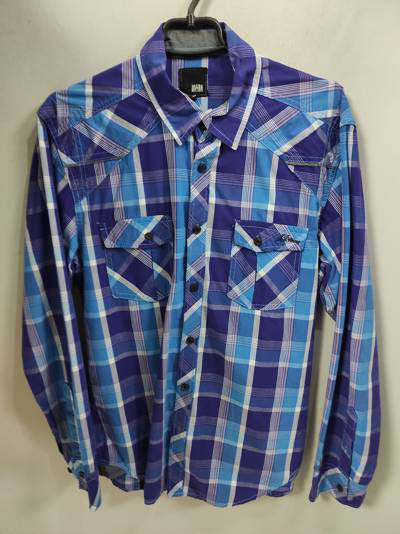

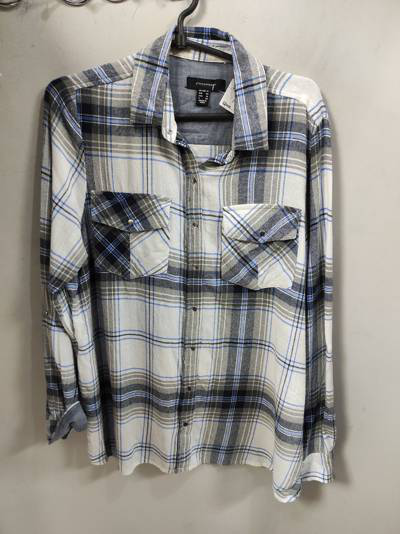

In [ ]:
query("blue checked men shirt",2)